In [1]:
import pandas as pd
import re
import numpy as np
import snowballstemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import preprocessor as p
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("InformationSeeking.csv", encoding='utf-8', index_col=False) #Loading the data
len(data)

499

In [3]:
data.columns

Index(['Text', 'IS/NO?'], dtype='object')

# Cleaning the Tweets

In [4]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)
def clean_tweet(row):
    text = p.clean(row['Text'])
    row['filtered_tweet'] = re.sub('\d', 'NUM', text)
    return row
data = data.apply(lambda row: clean_tweet(row), axis =1)

In [5]:
data = data[pd.notnull(data['filtered_tweet'])]
data = data[pd.notnull(data['IS/NO?'])]
len(data)

498

In [6]:
data['IS/NO?'].value_counts()

0.0    455
1.0     43
Name: IS/NO?, dtype: int64

# Over Sampling

In [7]:
values = []
for idx, val in data.iterrows():
    if val['IS/NO?'] == 1:
        for i in range(5):
            values.append(val)
    else:
        values.append(val)
data = pd.DataFrame(values)

In [8]:
data['IS/NO?'].value_counts()

0.0    455
1.0    215
Name: IS/NO?, dtype: int64

In [9]:
data = data.sample(frac=1, random_state=7).reset_index(drop=True)

In [10]:
data.head(5)

,Text,IS/NO?,filtered_tweet
0,Tell us there's cure instead....\n\nI said on ...,0.0,Tell us there's cure instead.... I said on beh...
1,Tencent may have accidentally leaked real dat....,0.0,Tencent may have accidentally leaked real dat....
2,Some #businesscontinuity examples of the impac...,0.0,Some #businesscontinuity examples of the impac...
3,Canadian scientists pioneer mask that kills vi...,0.0,Canadian scientists pioneer mask that kills vi...
4,So why did the DoD pick here in #Nebraska? L...,1.0,So why did the DoD pick here in #Nebraska? Log...


# TF-IDF Vectorization

In [11]:
english_stemmer = snowballstemmer.stemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [12]:
tfidf_vect = StemmedTfidfVectorizer(min_df=5, stop_words='english', analyzer='word', ngram_range=(1,2), max_features=2500, norm='l2', encoding='utf-8')

In [13]:
sentence_term_tfidf = tfidf_vect.fit_transform(data['filtered_tweet'])
sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tfidf_vect.vocabulary_.keys())))
sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_'+'_'+x)

In [14]:
sentence_term_df.head(5)

,W__account,W__account follow,W__acrual,W__actual,W__affect,W__affecting asian,W__africa,W__africa south,W__agenc,W__agencies believ,...,W__world,W__world countri,W__worri,W__wtf,W__wtf happen,W__wuhan,W__wuhan china,W__wuhan coronavirus,W__youtub,W__youtube coronavirus
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.203333,0.254683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
sentence_term_df.shape

(670, 563)

In [16]:
labels = data['IS/NO?']
labels.shape

(670,)

In [17]:
features = sentence_term_df.values

In [18]:
features.shape

(670, 563)

# Train - Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [20]:
len(X_train), len(X_test)

(469, 201)

# Print Classification Report

In [21]:
## For printing CLassification report with Accuracy
def print_classification_result(y_test, y_pred):
    target_names = ['Non-Information Seeking', 'Information Seeking']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Avg. Accuracy: ', accuracy_score(y_test, y_pred))

# Naive Bayes

In [22]:
## Multinomial Naive Bayes
mn_model = MultinomialNB(alpha=0)
mn_trained = mn_model.fit(X_train,y_train)
y_pred = mn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                         precision    recall  f1-score   support

Non-Information Seeking       1.00      0.96      0.98       141
    Information Seeking       0.92      1.00      0.96        60

               accuracy                           0.98       201
              macro avg       0.96      0.98      0.97       201
           weighted avg       0.98      0.98      0.98       201

Avg. Accuracy:  0.9751243781094527


C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [23]:
## Multinomial Naive Bayes
mn_model = MultinomialNB(alpha=1)
mn_trained = mn_model.fit(X_train,y_train)
y_pred = mn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                         precision    recall  f1-score   support

Non-Information Seeking       0.92      0.99      0.96       141
    Information Seeking       0.98      0.80      0.88        60

               accuracy                           0.94       201
              macro avg       0.95      0.90      0.92       201
           weighted avg       0.94      0.94      0.93       201

Avg. Accuracy:  0.9353233830845771


# Logistic Regression

In [24]:
lg_model = LogisticRegression(random_state=0)
lg_trained = lg_model.fit(X_train,y_train)
y_pred = lg_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                         precision    recall  f1-score   support

Non-Information Seeking       0.94      1.00      0.97       141
    Information Seeking       1.00      0.85      0.92        60

               accuracy                           0.96       201
              macro avg       0.97      0.93      0.94       201
           weighted avg       0.96      0.96      0.95       201

Avg. Accuracy:  0.9552238805970149


In [25]:
## Intercept
lg_trained.intercept_

array([-0.68945796])

In [26]:
lg_trained.coef_

array([[ 4.90745524e-01,  4.90745524e-01,  2.71745228e-01,
         2.82826963e-01,  4.62949813e-01,  4.75778474e-01,
         3.10490245e-01,  3.97711252e-01,  4.81896465e-01,
         5.96913564e-01, -1.97081722e-01,  3.64961411e-02,
         3.17623269e-01,  5.12557253e-01,  3.11248397e-01,
         3.97711252e-01, -3.04776116e-01, -1.29727150e+00,
        -1.38866679e-01, -3.18226829e-01,  3.50228640e-01,
         3.50228640e-01,  1.39187782e-01,  9.25899627e-01,
         4.75778474e-01,  2.98249308e-01,  4.75778474e-01,
         4.10326932e-01,  5.76203802e-01,  6.54571172e-02,
         2.36074642e-01,  3.86301892e-01,  3.86301892e-01,
         4.28171649e-01,  2.71745228e-01,  5.02821750e-01,
         5.02821750e-01,  3.50228640e-01,  3.50228640e-01,
         3.97711252e-01,  3.97711252e-01, -2.03369419e-01,
        -1.85145113e-01,  5.76203802e-01,  5.76203802e-01,
        -3.19626260e-01, -4.11678296e-01, -1.37633222e-01,
         9.42799989e-02,  2.71745228e-01,  2.71745228e-0

In [27]:
import statsmodels.api as sm
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

In [28]:
sig_indices = []
p_list = p_values.to_list()
for i in range(len(p_list)):
    if p_list[i] < 0.05:
        sig_indices.append(i)
len(sig_indices)

327

In [29]:
import math

In [30]:
sig_features = []
feat_names = list(sentence_term_df.columns)
co_effs = list(lg_trained.coef_[0])
for i in sig_indices:
    entry = {}
    score = p_list[i]
    feature_n = feat_names[i]
    entry['name'] = feature_n
    entry['score'] = score
    entry['coeff'] = co_effs[i]
    entry['odd_ratio'] = math.exp(co_effs[i])
    sig_features.append(entry)

In [31]:
## Finding Significant Features
sorted(sig_features, key = lambda i: i['score'])[0:10]

[{'name': 'W__truth',
  'score': 1.4626341237622353e-65,
  'coeff': 1.0882564546687705,
  'odd_ratio': 2.9690928090864888},
 {'name': 'W__account follow',
  'score': 1.3652753762354188e-54,
  'coeff': 0.49074552381357134,
  'odd_ratio': 1.6335336043067608},
 {'name': 'W__crossstreamw',
  'score': 1.3652753762380442e-54,
  'coeff': 0.49074552381357134,
  'odd_ratio': 1.6335336043067608},
 {'name': 'W__crossstreamw suggest',
  'score': 1.365275376238297e-54,
  'coeff': 0.49074552381357134,
  'odd_ratio': 1.6335336043067608},
 {'name': 'W__suggest english',
  'score': 1.3652753762390744e-54,
  'coeff': 0.49074552381357134,
  'odd_ratio': 1.6335336043067608},
 {'name': 'W__english',
  'score': 1.3652753762391332e-54,
  'coeff': 0.49074552381357134,
  'odd_ratio': 1.6335336043067608},
 {'name': 'W__suggest',
  'score': 1.3652753762391332e-54,
  'coeff': 0.49074552381357134,
  'odd_ratio': 1.6335336043067608},
 {'name': 'W__english account',
  'score': 1.3652753762396192e-54,
  'coeff': 0.49

In [32]:
## Log-odd and odd-ratio
# odds_ratio
np.exp(lg_trained.coef_)

array([[1.6335336 , 1.6335336 , 1.31225263, 1.32687554, 1.58875361,
        1.60926648, 1.36409369, 1.48841419, 1.61914214, 1.81650362,
        0.82112353, 1.0371703 , 1.37385859, 1.66955522, 1.36512827,
        1.48841419, 0.73728842, 0.27327641, 0.87034406, 0.72743777,
        1.41939204, 1.41939204, 1.14933991, 2.52413802, 1.60926648,
        1.34749769, 1.60926648, 1.50731049, 1.77927113, 1.06764695,
        1.26626882, 1.47152885, 1.47152885, 1.53444944, 1.31225263,
        1.65338012, 1.65338012, 1.41939204, 1.41939204, 1.48841419,
        1.48841419, 0.81597675, 0.83098369, 1.77927113, 1.77927113,
        0.72642048, 0.66253738, 0.87141825, 1.09886738, 1.31225263,
        1.31225263, 1.31225263, 1.47626858, 1.47626858, 0.65523048,
        1.35849511, 1.70537219, 1.72076551, 1.47152885, 1.5082391 ,
        1.82042807, 0.36885088, 1.2669698 , 0.88391297, 0.58374819,
        0.96019948, 1.48841419, 1.77927113, 1.77927113, 1.01164054,
        1.25114254, 1.88748742, 0.8441893 , 1.25

# Decision Tree

In [33]:
## Original data Distribution
sentence_term_df['W__truth'].describe()

count    670.000000
mean       0.015414
std        0.109517
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: W__truth, dtype: float64

In [34]:
sentence_term_df['lables'] = labels

In [35]:
# Shuffle and show new distribution

In [36]:
sentence_term_df_shuffle = sentence_term_df.sample(frac=1, random_state=100).reset_index(drop=True)

In [37]:
sentence_term_df_shuffle['W__truth'].describe()

count    670.000000
mean       0.015414
std        0.109517
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: W__truth, dtype: float64

In [38]:
## Training - Testing Split
sentence_term_df_shuffle.shape

(670, 564)

In [39]:
features = sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].values
features.shape

(670, 563)

In [40]:
lables = sentence_term_df_shuffle['lables']
lables.shape

(670,)

In [41]:
## Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [42]:
## Training Decision tree
dt_model = DecisionTreeClassifier()
dt_trained = dt_model.fit(X_train,y_train)

In [43]:
## Size of the tree
treeObj = dt_trained.tree_
treeObj.node_count

275

In [44]:
## Tree Visualization
from sklearn import tree

from sklearn.tree.export import export_text 
 

C:\Users\Shreeya\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [45]:
feature_names = list(sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].columns)
feature_names

['W__account',
 'W__account follow',
 'W__acrual',
 'W__actual',
 'W__affect',
 'W__affecting asian',
 'W__africa',
 'W__africa south',
 'W__agenc',
 'W__agencies believ',
 'W__alarm',
 'W__aliv',
 'W__alive western',
 'W__allegedl',
 'W__america',
 'W__america saf',
 'W__american',
 'W__amp',
 'W__amp follow',
 'W__announc',
 'W__aren',
 'W__aren numnumnumnum',
 'W__arrest',
 'W__asian',
 'W__asian cas',
 'W__asiannetwalk',
 'W__asians non',
 'W__australia',
 'W__australia head',
 'W__ban',
 'W__bans wid',
 'W__behold',
 'W__behold superpow',
 'W__believ',
 'W__believe acru',
 'W__bill',
 'W__bills gonna',
 'W__bnodesk',
 'W__bnodesk aren',
 'W__boarder',
 'W__boarders ear',
 'W__break',
 'W__british',
 'W__bushfir',
 'W__bushfires coronavirus',
 'W__care',
 'W__case',
 'W__cases coronavirus',
 'W__ccp',
 'W__ccp li',
 'W__check',
 'W__check ccp',
 'W__chicago',
 'W__chicago just',
 'W__china',
 'W__china coronavirus',
 'W__china given',
 'W__china reduct',
 'W__china ref',
 'W__china

In [46]:
r = export_text(dt_trained, feature_names=feature_names)
print(r)

|--- W__rip <= 0.34
|   |--- W__confirm <= 0.38
|   |   |--- W__hope <= 0.45
|   |   |   |--- W__fear <= 0.53
|   |   |   |   |--- W__tell <= 0.56
|   |   |   |   |   |--- W__pandem <= 0.20
|   |   |   |   |   |   |--- W__government ag <= 0.24
|   |   |   |   |   |   |   |--- W__coronavirus <= 0.23
|   |   |   |   |   |   |   |   |--- W__new <= 0.27
|   |   |   |   |   |   |   |   |   |--- W__china <= 0.37
|   |   |   |   |   |   |   |   |   |   |--- W__number <= 0.47
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 81
|   |   |   |   |   |   |   |   |   |   |--- W__number >  0.47
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- W__china >  0.37
|   |   |   |   |   |   |   |   |   |   |--- W__watch <= 0.27
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |   |--- W__watch >  0.27
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   

In [47]:
## Training Confusion Matrix
y_pred = dt_trained.predict(X_train)
print_classification_result(y_train, y_pred)

                         precision    recall  f1-score   support

Non-Information Seeking       0.87      0.96      0.91       314
    Information Seeking       0.91      0.70      0.79       155

               accuracy                           0.88       469
              macro avg       0.89      0.83      0.85       469
           weighted avg       0.88      0.88      0.87       469

Avg. Accuracy:  0.8763326226012793


In [48]:
## Testing Confusion Matrix
y_pred = dt_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                         precision    recall  f1-score   support

Non-Information Seeking       0.69      0.74      0.71       141
    Information Seeking       0.27      0.23      0.25        60

               accuracy                           0.59       201
              macro avg       0.48      0.49      0.48       201
           weighted avg       0.57      0.59      0.58       201

Avg. Accuracy:  0.5870646766169154


In [49]:
## Boosting Performance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score

In [50]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)

In [51]:
score_df = pd.DataFrame(score_list)

In [52]:
score_df

,count,accuracy,precision,recall
0,100,0.835821,0.470588,0.880000
1,110,0.840796,0.470588,0.870968
2,120,0.845771,0.509804,0.823529
3,130,0.840796,0.549020,0.875000
4,140,0.860697,0.529412,0.823529
5,150,0.865672,0.529412,0.848485


In [53]:
import matplotlib.pyplot as plt

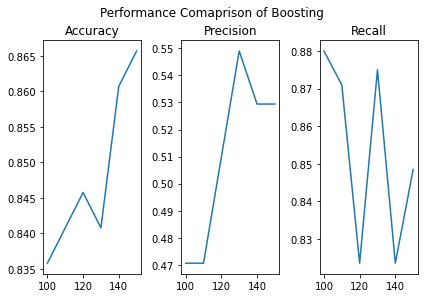

In [54]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Boosting', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
fig.tight_layout()

In [64]:
## Bagging
from sklearn.ensemble import BaggingClassifier

In [59]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)
score_df = pd.DataFrame(score_list)
score_df

,count,accuracy,precision,recall
0,100,0.855721,0.607843,0.820513
1,110,0.855721,0.607843,0.815789
2,120,0.880597,0.647059,0.800000
3,130,0.865672,0.627451,0.815789
4,140,0.860697,0.627451,0.711111
5,150,0.875622,0.607843,0.837838


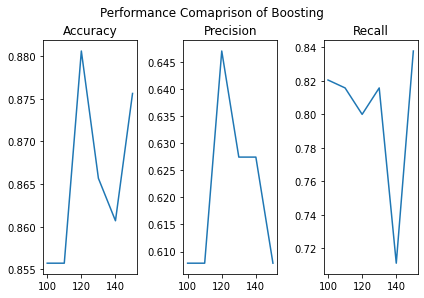

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Boosting', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
fig.tight_layout()

# Random Forest

In [65]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)
score_df = pd.DataFrame(score_list)

In [66]:
score_df

,count,accuracy,precision,recall
0,100,0.830846,0.568627,0.783784
1,110,0.840796,0.607843,0.794118
2,120,0.870647,0.549020,0.891892
3,130,0.850746,0.607843,0.810811
4,140,0.850746,0.568627,0.794872
5,150,0.840796,0.568627,0.783784


Text(0.5, 1.0, 'Recall')

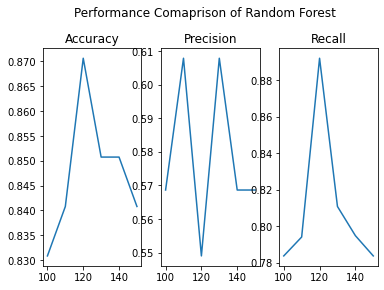

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Random Forest', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
# fig.tight_layout()

In [68]:
for step in [100,110,120,130, 140, 150]:
    clf = RandomForestClassifier(n_estimators=step)
    clf.fit(X_train, y_train)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    best_10 = indices[0:10]
    print("=============For Tree Count " + str(step) + " ===================")
    for i in best_10:
        print(feature_names[i])

=============For Tree Count 100 ===================
W__coronavirus
W__fear
W__tell
W__rip
W__number
W__china
W__confirm
W__great
W__start
W__hope
=============For Tree Count 110 ===================
W__coronavirus
W__fear
W__china
W__tell
W__confirm
W__hope
W__rip
W__number
W__report
W__start
=============For Tree Count 120 ===================
W__coronavirus
W__fear
W__china
W__tell
W__rip
W__hope
W__great
W__confirm
W__report
W__new
=============For Tree Count 130 ===================
W__coronavirus
W__fear
W__tell
W__china
W__rip
W__hope
W__number
W__great
W__confirm
W__report
=============For Tree Count 140 ===================
W__coronavirus
W__fear
W__rip
W__confirm
W__hope
W__tell
W__china
W__report
W__number
W__start
=============For Tree Count 150 ===================
W__coronavirus
W__fear
W__rip
W__tell
W__hope
W__confirm
W__china
W__number
W__report
W__great
